# Bay Area Bike Share Analysis

## Introduction


[Bay Area Bike Share](http://www.bayareabikeshare.com/) is a company that provides on-demand bike rentals for customers in San Francisco, Redwood City, Palo Alto, Mountain View, and San Jose. Users can unlock bikes from a variety of stations throughout each city, and return them to any station within the same city. Users pay for the service either through a yearly subscription or by purchasing 3-day or 24-hour passes. Users can make an unlimited number of trips, with trips under thirty minutes in length having no additional charge; longer trips will incur overtime fees.

In this project, I will take a look at two of the major parts of the data analysis process: data wrangling and exploratory data analysis. But before you even start looking at data, it is important to have clear the goal of the data analysis. In particular, we want to answer the following questions:

Q1: How is service demand distributed in each city? 
Q2: What are the most ridden routes (from unlock station to return station)?
Q3: Are there any correlations between unlock / return rates and characteristics of the city district (such as average district age / presence of schools / presence of companies / population)? Using these information, we can add new stations or move existing stations to improve the service
Q4: Can we predict the sharing usage to predict bike's availability to the users according to the day / hour / season?
Q5: how is the subscription rate? how each category of users uses the service?

  

## Data Wrangling

Year 1 and Year 2 data from the Bay Area Bike Share's [Open Data](http://www.bayareabikeshare.com/open-data) page have already been provided with the project materials; you don't need to download anything extra. The data comes in three parts: the first half of Year 1 (files starting `201402`), the second half of Year 1 (files starting `201408`), and all of Year 2 (files starting `201508`). There are three main datafiles associated with each part: trip data showing information about each trip taken in the system (`*_trip_data.csv`), information about the stations in the system (`*_station_data.csv`), and daily weather data for each city in the system (`*_weather_data.csv`).

When dealing with a lot of data, it can be useful to start by working with only a sample of the data. This way, it will be much easier to check that our data wrangling steps are working since our code will take less time to complete. Once we are satisfied with the way things are working, we can then set things up to work on the dataset as a whole.

Since the bulk of the data is contained in the trip information, we should target looking at a subset of the trip data to help us get our bearings. You'll start by looking at only the first month of the bike trip data, from 2013-08-29 to 2013-09-30. The code below will take the data from the first half of the first year, then write the first month's worth of data to an output file. This code exploits the fact that the data is sorted by date (though it should be noted that the first two days are sorted by trip time, rather than being completely chronological).



In [1]:
# import all necessary packages and functions.
import csv
from datetime import datetime
import numpy as np
import pandas as pd
from babs_datacheck import question_3
from babs_visualizations import usage_stats, usage_plot
from IPython.display import display
%matplotlib inline

In [2]:
# file locations
file_in  = '201402_trip_data.csv'
file_out = '201309_trip_data.csv'

# Open csv file and write new file with data from the first month only
with open(file_out, 'w') as f_out, open(file_in, 'r') as f_in:
    # set up csv reader and writer objects
    in_reader = csv.reader(f_in)
    out_writer = csv.writer(f_out)

    # write rows from in-file to out-file until specified date reached
    while True:
        datarow = next(in_reader)
        # trip start dates in 3rd column, m/d/yyyy HH:MM formats
        if datarow[2][:9] == '10/1/2013':
            break
        out_writer.writerow(datarow)

### Condensing the Trip Data

The first step is to look at the structure of the dataset to see if there's any data wrangling we should perform. The below cell will read in the sampled data file that I created in the previous cell, and print out the first few rows of the table.

In [3]:
sample_data = pd.read_csv('201309_trip_data.csv')

display(sample_data.head())

display(sample_data.info())

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscription Type,Zip Code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27345 entries, 0 to 27344
Data columns (total 11 columns):
Trip ID              27345 non-null int64
Duration             27345 non-null int64
Start Date           27345 non-null object
Start Station        27345 non-null object
Start Terminal       27345 non-null int64
End Date             27345 non-null object
End Station          27345 non-null object
End Terminal         27345 non-null int64
Bike #               27345 non-null int64
Subscription Type    27345 non-null object
Zip Code             25293 non-null object
dtypes: int64(5), object(6)
memory usage: 2.3+ MB


None

In this exploration, we're going to concentrate on factors in the trip data that affect the number of trips that are taken. Let's focus down on a few selected columns: the trip duration, start time, start terminal, end terminal, and subscription type. Start time will be divided into year, month, and hour components. We will also add a column for the day of the week and abstract the start and end terminal to be the start and end _city_.

Let's tackle the lattermost part of the wrangling process first. Run the below code cell to see how the station information is structured, then observe how the code will create the station-city mapping. Note that the station mapping is set up as a function, `create_station_mapping()`. Since it is possible that more stations are added or dropped over time, this function will allow us to combine the station information across all three parts of our data when we are ready to explore everything.

In [4]:
# Load new data file: data on stations
# Display the first few rows of the station data file.
station_info = pd.read_csv('201402_station_data.csv')
display(station_info.head())
display(station_info.info())

# This function will be called by another function later on to create the mapping.
def create_station_mapping(station_data):
    """
    Create a mapping from station IDs to cities, returning the
    result as a dictionary.
    """
    station_map = {}  # initialize empty array
    for data_file in station_data:
        with open(data_file, 'r') as f_in:
            # set up csv reader object - note that we are using DictReader, which
            # takes the first row of the file as a header row for each row's
            # dictionary keys
            weather_reader = csv.DictReader(f_in)

            for row in weather_reader:
                station_map[row['station_id']] = row['landmark']
    return station_map

,station_id,name,lat,long,dockcount,landmark,installation
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 7 columns):
station_id      69 non-null int64
name            69 non-null object
lat             69 non-null float64
long            69 non-null float64
dockcount       69 non-null int64
landmark        69 non-null object
installation    69 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 3.9+ KB


None

I can now use the mapping to condense the trip data to the selected columns noted above. This will be performed in the `summarise_data()` function below. As part of this function, the `datetime` module is used to **p**arse the timestamp strings from the original data file as datetime objects (`strptime`), which can then be output in a different string **f**ormat (`strftime`). The parsed objects also have a variety of attributes and methods to quickly obtain


In [5]:
def summarise_data(trip_in, station_data, trip_out):
    """
    This function takes trip and station information and outputs a new
    data file with a condensed summary of major trip information. The
    trip_in and station_data arguments will be lists of data files for
    the trip and station information, respectively, while trip_out
    specifies the location to which the summarized data will be written.
    """
    # generate dictionary of station - city mapping
    station_map = create_station_mapping(station_data)
    
    with open(trip_out, 'w') as f_out:
        # set up csv writer object        
        out_colnames = ['duration', 'start_date', 'start_year',
                        'start_month', 'start_hour', 'weekday',
                        'start_city', 'end_city', 'subscription_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        for data_file in trip_in:
            with open(data_file, 'r') as f_in:
                # set up csv reader object
                trip_reader = csv.DictReader(f_in)

                # collect data from and process each row
                for row in trip_reader:
                    new_point = {}
                    
                    # convert duration units from seconds to minutes
                    # new_point['duration'] = float(row['Duration'])/60
                    new_point['duration'] = float(row['Duration'])/60
                    
                    # reformat datestrings into multiple columns
                    ### Question 3b: Fill in the blanks below to generate ###
                    ### the expected time values.                         ###
                    trip_date = datetime.strptime(row['Start Date'], '%m/%d/%Y %H:%M')
                    new_point['start_date']  = trip_date.strftime('%Y-%m-%d')
                    new_point['start_year']  = trip_date.strftime('%Y')
                    new_point['start_month'] = trip_date.strftime('%m')
                    new_point['start_hour']  = trip_date.strftime('%H')
                    new_point['weekday']     = trip_date.isoweekday() # Monday is 1 and Sunday is 7
                    
                    # remap start and end terminal with start and end city
                    new_point['start_city'] = station_map[row['Start Terminal']]
                    new_point['end_city'] = station_map[row['End Terminal']]
                    # two different column names for subscribers depending on file
                    if 'Subscription Type' in row:
                        new_point['subscription_type'] = row['Subscription Type']
                    else:
                        new_point['subscription_type'] = row['Subscriber Type']

                    # write the processed information to the output file.
                    trip_writer.writerow(new_point)

In [6]:
# Process the data by running the function we wrote above.
station_data = ['201402_station_data.csv']
trip_in = ['201309_trip_data.csv']
trip_out = '201309_trip_summary.csv'
summarise_data(trip_in, station_data, trip_out)

# Load in the data file and print out the first few rows
sample_data = pd.read_csv(trip_out)
display(sample_data.head())

# Verify the dataframe by counting data points matching each of the time features.
question_3(sample_data)

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,4,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,4,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,4,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,4,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,4,San Francisco,San Francisco,Subscriber


All counts are as expected!



## Exploratory Data Analysis

Let's look at some initial trends in the data.

In [7]:
trip_data = pd.read_csv('201309_trip_summary.csv')

usage_stats(trip_data)

There are 27345 data points in the dataset.
The average duration of trips is 27.60 minutes.
The median trip duration is 10.72 minutes.
25% of trips are shorter than 6.82 minutes.
25% of trips are longer than 17.28 minutes.


array([  6.81666667,  10.71666667,  17.28333333])

There are over 27,000 trips in the first month, and that the average trip duration is larger than the median trip duration (the point where 50% of trips are shorter, and 50% are longer). In fact, the mean is larger than the 75% shortest durations. This will be interesting to look at later on.

Let's start looking at how those trips are divided by subscription type. One easy way to build an intuition about the data is to plot it. We'll use the `usage_plot()` function for this. The second argument of the function allows us to count up the trips across a selected variable, displaying the information in a plot. The expression below will show how many customer and how many subscriber trips were made. Try it out!

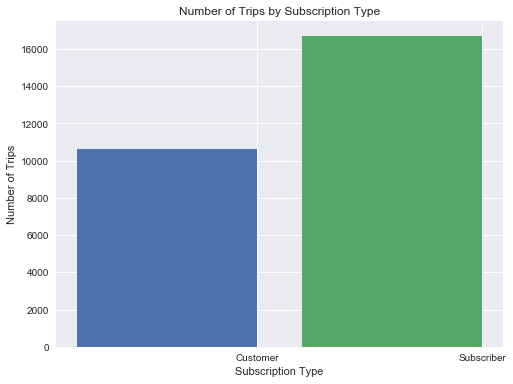

In [8]:
usage_plot(trip_data, 'subscription_type')

Seems like there's about 50% more trips made by subscribers in the first month than customers. Let's try a different variable now. What does the distribution of trip durations look like?

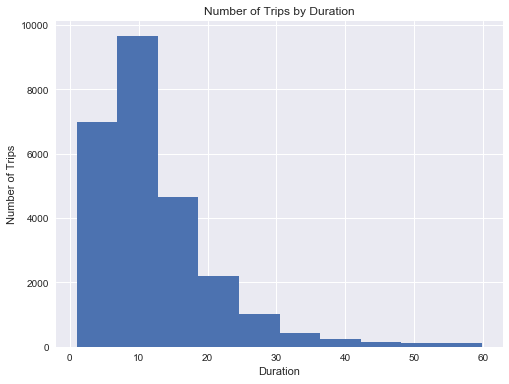

In [10]:
usage_plot(trip_data, 'duration', ['duration < 60'])

Most trips are indeed less than 30 minutes in length.

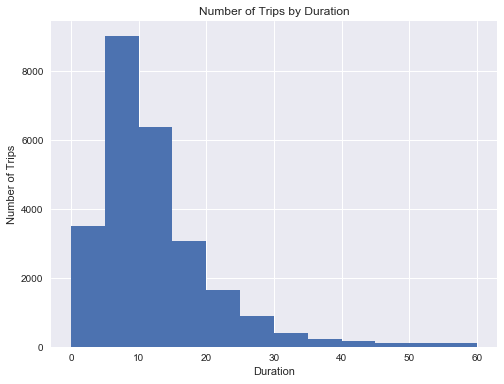

In [11]:
usage_plot(trip_data, 'duration', ['duration < 60'], boundary = 0, bin_width = 5)

The previous histogram shows that about 9000 trips have duration between 5 min and 10 min


## Performing Analysis

Process all the data into a single data file. Note that the function will not display any output while it runs, and this can take a while to complete. 

In [12]:
station_data = ['201402_station_data.csv',
                '201408_station_data.csv',
                '201508_station_data.csv' ]
trip_in = ['201402_trip_data.csv',
           '201408_trip_data.csv',
           '201508_trip_data.csv' ]
trip_out = 'babs_y1_y2_summary.csv'

# This function will take in the station data and trip data and
# write out a new data file to the name listed above in trip_out.
summarise_data(trip_in, station_data, trip_out)

Since the `summarise_data()` function has created a standalone file, the above cell will not need to be run a second time, even if you close the notebook and start a new session. 

In [13]:
trip_data = pd.read_csv('babs_y1_y2_summary.csv')
display(trip_data.head())
display(trip_data.info())

,duration,start_date,start_year,start_month,start_hour,weekday,start_city,end_city,subscription_type
0,1.050000,2013-08-29,2013,8,14,4,San Francisco,San Francisco,Subscriber
1,1.166667,2013-08-29,2013,8,14,4,San Jose,San Jose,Subscriber
2,1.183333,2013-08-29,2013,8,10,4,Mountain View,Mountain View,Subscriber
3,1.283333,2013-08-29,2013,8,11,4,San Jose,San Jose,Subscriber
4,1.383333,2013-08-29,2013,8,12,4,San Francisco,San Francisco,Subscriber


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669959 entries, 0 to 669958
Data columns (total 9 columns):
duration             669959 non-null float64
start_date           669959 non-null object
start_year           669959 non-null int64
start_month          669959 non-null int64
start_hour           669959 non-null int64
weekday              669959 non-null int64
start_city           669959 non-null object
end_city             669959 non-null object
subscription_type    669959 non-null object
dtypes: float64(1), int64(4), object(4)
memory usage: 46.0+ MB


None

In [14]:
usage_stats(trip_data)

There are 669959 data points in the dataset.
The average duration of trips is 18.47 minutes.
The median trip duration is 8.62 minutes.
25% of trips are shorter than 5.73 minutes.
25% of trips are longer than 12.58 minutes.


array([  5.73333333,   8.61666667,  12.58333333])

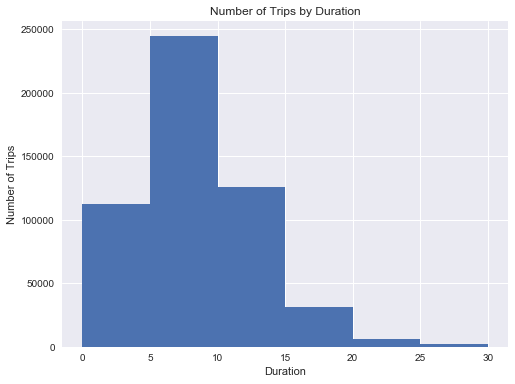

In [16]:
usage_plot(trip_data,'duration',["duration < 30", "subscription_type == 'Subscriber'", "weekday < 6"],bin_width=5,boundary = 0)

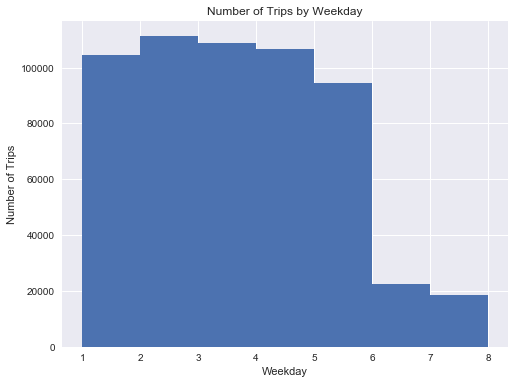

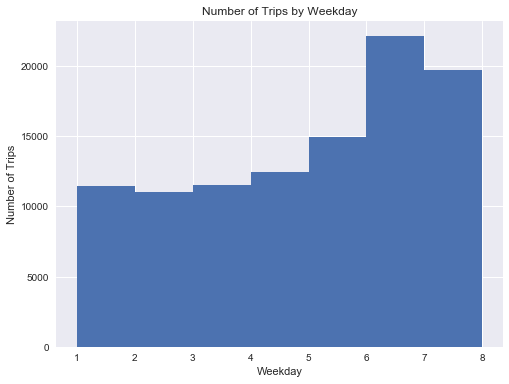

In [17]:
usage_plot(trip_data,'weekday',[ "subscription_type == 'Subscriber'"],bin_width=1,boundary = 1)
usage_plot(trip_data,'weekday',[ "subscription_type == 'Customer'"],bin_width=1,boundary = 1)


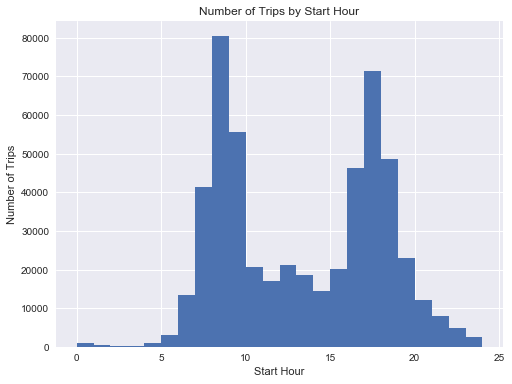

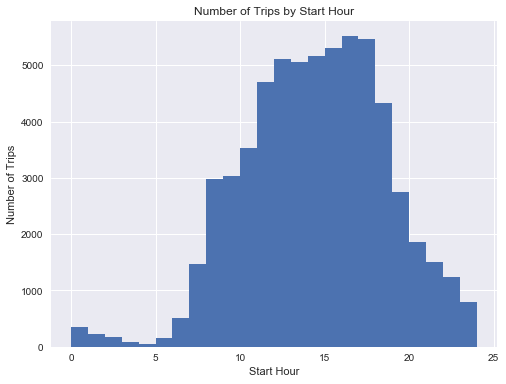

In [18]:
usage_plot(trip_data,'start_hour',["subscription_type == 'Subscriber'","weekday < 6"],bin_width=1,boundary = 6)
usage_plot(trip_data,'start_hour',["subscription_type == 'Customer'","weekday < 6"],bin_width=1,boundary = 6)

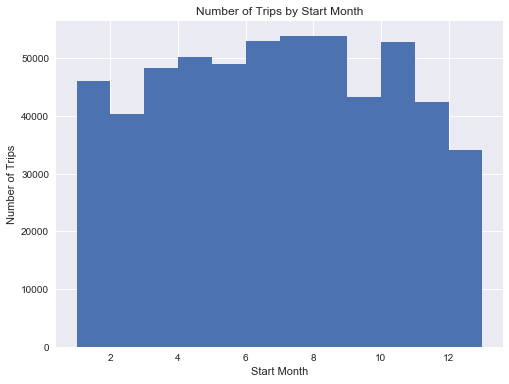

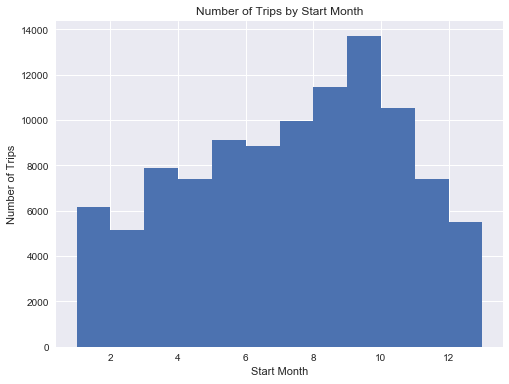

In [19]:
usage_plot(trip_data,'start_month',["subscription_type == 'Subscriber'"],bin_width=1,boundary = 1)
usage_plot(trip_data,'start_month',["subscription_type == 'Customer'"],bin_width=1,boundary = 1)

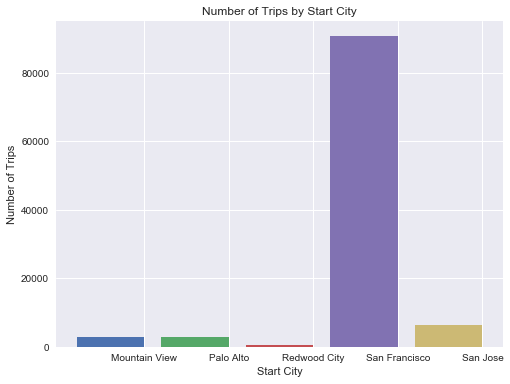

In [20]:
usage_plot(trip_data,'start_city',["subscription_type == 'Customer'"],n_bins=5,bin_width=1)

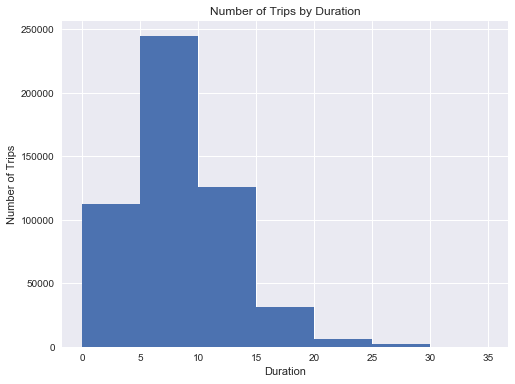

In [22]:
usage_plot(trip_data,'duration',["duration <= 30","subscription_type == 'Subscriber'","weekday < 6"],bin_width=5,boundary = 0)

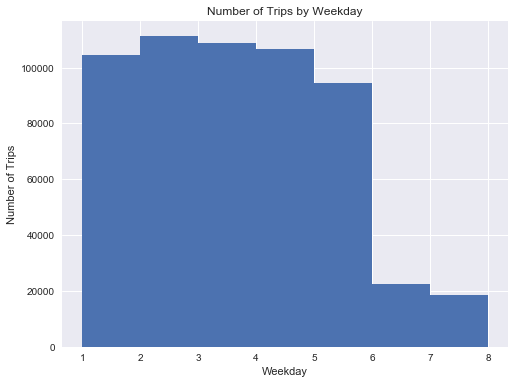

In [23]:
# Final Plot 1
usage_plot(trip_data,'weekday',[ "subscription_type == 'Subscriber'"],bin_width=1,boundary = 1)

This histogram shows how the annual subscribers use the bike sharing service during the week. As we can observe, these users take the bike during weekdays, meaning that they use the service to commute for working. I selected this graph because it provides several useful insights:
1- the bike sharing service is used daily for commuting. 
2- since the service is used for commuting, I expect relatively short duration of rides
3- Peaks of usage should appear in rush hours 
4- I can expect that the most used stations are located in areas nearby companies 

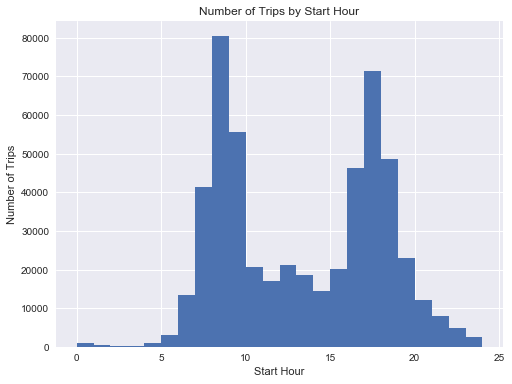

In [26]:
# Final Plot 2
usage_plot(trip_data,'start_hour',["subscription_type == 'Subscriber'","weekday < 6"],bin_width=1,boundary = 6)

 Following the insights from visualization 1, this histogram shows that annual subscribers mostly use the sharing service during rush hours 7-10 am and 4-7 pm. This is interesting because it indicates that:
1- there are two fluxes of rides: one towards companies in 7-10 am, one jurney backward at 4-7 pm.
2- Due to the usage for commuting, the service can be potentially improved by installing new statons near large companies